#Getting started with Lasagne

This workbook contains the code for this blog post:
http://luizgh.github.io/libraries/2015/12/08/getting-started-with-lasagne

Here we train a CNN on the MNIST dataset using the Lasagne library (that needs to be installed before running this workbook)
http://lasagne.readthedocs.org/en/latest/user/installation.html


## Import libraries

In [1]:
#For running the model:
import lasagne
import theano
from theano import tensor as T
import numpy as np

#For loading the dataset:
import os
import gzip
import cPickle
import urllib

Using gpu device 0: Tesla C2050 (CNMeM is disabled)


## Define input / output shape and symbolic variables

In [2]:
data_size=(None,1,28,28) # Batch size x Img Channels x Height x Width
output_size=10 # We will run the example in mnist - 10 digits

input_var = T.tensor4('input')
target_var = T.ivector('targets')

##Define the model

In [3]:
net = {}

#Input layer:
net['data'] = lasagne.layers.InputLayer(data_size, input_var=input_var)

#Convolution + Pooling
net['conv1'] = lasagne.layers.Conv2DLayer(net['data'], num_filters=6, filter_size=5)
net['pool1'] = lasagne.layers.Pool2DLayer(net['conv1'], pool_size=2)

net['conv2'] = lasagne.layers.Conv2DLayer(net['pool1'], num_filters=10, filter_size=5)
net['pool2'] = lasagne.layers.Pool2DLayer(net['conv2'], pool_size=2)


#Fully-connected + dropout
net['fc1'] = lasagne.layers.DenseLayer(net['pool2'], num_units=100)
net['drop1'] = lasagne.layers.DropoutLayer(net['fc1'],  p=0.5)

#Output layer:
net['out'] = lasagne.layers.DenseLayer(net['drop1'], num_units=output_size, 
                                       nonlinearity=lasagne.nonlinearities.softmax)

#Note: Lasagne does not implement a class for "Model". Usually, you only need the output layer to:
# 1) Obtain the result of the layer (predictions)
# 2) Obtain a list of all parameters from the model (e.g. for weight decay)

##Define the cost function and update rule

In [4]:
#Define hyperparameters. These could also be symbolic variables 
lr = 1e-2
weight_decay = 1e-5


#Loss function: mean cross-entropy
prediction = lasagne.layers.get_output(net['out'])
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

#Also add weight decay to the cost function
weightsl2 = lasagne.regularization.regularize_network_params(net['out'], lasagne.regularization.l2)
loss += weight_decay * weightsl2

#Get the update rule. Here we will use a more advanced optimization algorithm: ADAM [1]
params = lasagne.layers.get_all_params(net['out'], trainable=True)
updates = lasagne.updates.adam(loss, params)

#[1] http://arxiv.org/abs/1412.6980

##Compile the training and test functions

In [5]:
test_prediction = lasagne.layers.get_output(net['out'], deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

#Note that train_fn has a "updates" rule. Whenever we call this function, it updates the parameters of the model.
train_fn = theano.function([input_var, target_var], loss, updates=updates, name='train')
val_fn = theano.function([input_var, target_var], [test_loss, test_acc], name='validation')
get_preds = theano.function([input_var], test_prediction, name='get_preds')


## Obtain dataset (MNIST)

In [6]:
dataset_file = 'mnist.pkl.gz'

#Download dataset if not yet done:
if not os.path.isfile(dataset_file):
    urllib.urlretrieve('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz', dataset_file)

#Load the dataset
f = gzip.open(dataset_file, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

#Convert the dataset to the shape we want
x_train, y_train = train_set
x_test, y_test = test_set

x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

## Train the model

In [7]:
import time
epochs = 50  #You can reduce the number of epochs to run it  faster (or run it for longer for a better model)
batch_size=100

#Run the training function per mini-batches
n_examples = x_train.shape[0]
n_batches = n_examples / batch_size

cost_history = []
for epoch in xrange(epochs):
    st = time.time()
    batch_cost_history = []
    for batch in xrange(n_batches):
        x_batch = x_train[batch*batch_size: (batch+1) * batch_size]
        y_batch = y_train[batch*batch_size: (batch+1) * batch_size]
        
        this_cost = train_fn(x_batch, y_batch) # This is where the model gets updated
        
        batch_cost_history.append(this_cost)
    epoch_cost = np.mean(batch_cost_history)
    cost_history.append(epoch_cost)
    en = time.time()
    print('Epoch %d/%d, train error: %f. Elapsed time: %.2f seconds' % (epoch+1, epochs, epoch_cost, en-st))

Epoch 1/50, train error: 0.561244. Elapsed time: 10.45 seconds
Epoch 2/50, train error: 0.198558. Elapsed time: 10.22 seconds
Epoch 3/50, train error: 0.148564. Elapsed time: 10.20 seconds
Epoch 4/50, train error: 0.120552. Elapsed time: 10.17 seconds
Epoch 5/50, train error: 0.104752. Elapsed time: 10.34 seconds
Epoch 6/50, train error: 0.094945. Elapsed time: 10.43 seconds
Epoch 7/50, train error: 0.086094. Elapsed time: 10.28 seconds
Epoch 8/50, train error: 0.081561. Elapsed time: 10.39 seconds
Epoch 9/50, train error: 0.074385. Elapsed time: 10.23 seconds
Epoch 10/50, train error: 0.072644. Elapsed time: 10.34 seconds
Epoch 11/50, train error: 0.067644. Elapsed time: 10.26 seconds
Epoch 12/50, train error: 0.062416. Elapsed time: 10.28 seconds
Epoch 13/50, train error: 0.060356. Elapsed time: 10.24 seconds
Epoch 14/50, train error: 0.057459. Elapsed time: 10.15 seconds
Epoch 15/50, train error: 0.057489. Elapsed time: 10.32 seconds
Epoch 16/50, train error: 0.055484. Elapsed time:

## Test the model

In [9]:
loss, acc = val_fn(x_test, y_test)
test_error = 1 - acc
print('Test error: %f' % test_error)

Test error: 0.009700


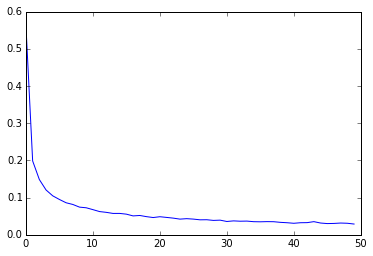

In [10]:
#Plot the cost history

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cost_history)

##Visualizing predictions

In [11]:
def PlotPredictions(test_samples, predictedLabels):
    plt.figure(figsize=(3,2))
    f, axarr = plt.subplots(2,5)
    for i in range(2):
        for j in range(5):
            index = i*5+j
            axarr[i,j].imshow(test_samples[index].reshape(28,28), cmap='Greys', interpolation='nearest')
            axarr[i,j].axis('off')
            axarr[i,j].set_title('%d' % predictedLabels[index])

Random examples


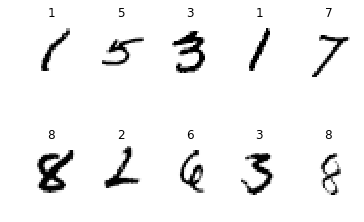

In [21]:
predictedLabels = get_preds(x_test).argmax(axis=1)

indices = np.random.choice(y_test.shape[0], replace=False, size=10)

PlotPredictions( x_test[indices], predictedLabels[indices])

print "Random examples"

plt.savefig("randompreds.png")

Incorrect predictions


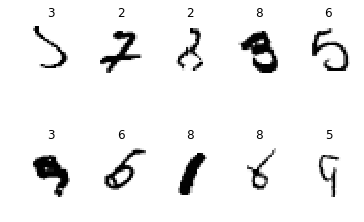

In [25]:
incorrectPreds = np.nonzero(predictedLabels != y_test)[0]
someIncorrectPreds = np.random.choice(incorrectPreds, replace=False, size=10)

PlotPredictions(x_test[someIncorrectPreds], predictedLabels[someIncorrectPreds])
print "Incorrect predictions"

plt.savefig("errors.png")

## Visualize the weights

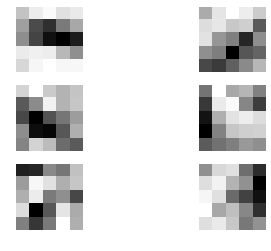

In [28]:
weights = net['conv1'].W.get_value()

plt.figure()
f, axarr = plt.subplots(3,2)
for i in range(3):
    for j in range(2):
        index = i*2+j
        axarr[i,j].imshow(weights[index].reshape(5,5), cmap='Greys_r', interpolation='nearest')
        axarr[i,j].axis('off')

## Other things you can easily do

* Add things to the cost function. Just add something to the "loss" variable that is used for defining the updates. Theano will take care of calculating the derivates with respect to the inputs
* Obtaining the representation from intermediate layers:

>output_at_layer_fc1 = lasagne.layers.get_output(fc1)

>get_representation = theano.function([input_var], output_at_layer_fc1)


* Augmenting the input - easy to do since you have direct control of what is being fed to the training function
* Using any type of learning rate schedule - you can define the learning rate as a theano shared variable, and set its value at any time in the computation (e.g. multiple by a value after each epoch, etc).
* Use it for fine-tuning. By default the weights are initialized for you, but you can use pre-trained weights if you have them:
> conv1 = lasagne.layers.Conv2DLayer(data, num_filters=32, filter_size=5, **W=pretrainedW, b=pretrainedB**)

